<a href="https://colab.research.google.com/github/JayasriPalanisamy/Fast-minutia-extractor/blob/main/data_loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
from glob import glob


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__


'2.1.0+cu121'

In [3]:
# Setup train and test paths
from pathlib import Path

train_path = '/content/drive/MyDrive/FVC2002/Dbs/Db1_a'
test_path = '/content/drive/MyDrive/FVC2002/Dbs/Db1_b'

train_folder = Path(train_path)
train_folder.mkdir(parents=True, exist_ok=True)

test_folder = Path(test_path)
test_folder.mkdir(parents=True, exist_ok=True)

In [4]:
len(list(train_folder.glob('*.tif')))

800

Random image path: /content/drive/MyDrive/FVC2002/Dbs/Db1_a/79_2.tif
Image class: Db1_a
Image height: 374
Image width: 388


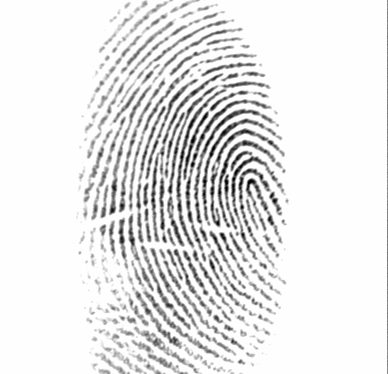

In [5]:
# Visualize one image
import random
from PIL import Image

random.seed(42)

parent_path = '/content/drive/MyDrive/FVC2002/Dbs/Db1_a/*.tif'
image_path_list = list(glob(parent_path))

random_image_path = Path(random.choice(image_path_list))

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [6]:
class ImageResizing(object):
  def __init__(self):
    pass

  def __call__(self, img):
    # Compute the aspect ratio
    aspect_ratio = img.width / img.height

    # Compute the target size
    new_width = 300
    new_height = int(new_width / aspect_ratio)

    # Resize the image
    img_resized = img.resize((new_width, new_height), Image.ANTIALIAS)

    # Create a new image with white background
    new_img = Image.new("L", (300, 300), "white")

    # Paste the resized image into the new image centered
    upper_left = (int((300 - new_width) / 2), int((300 - new_height) / 2))
    new_img.paste(img_resized, upper_left)

    # Save the new image
    return new_img

In [7]:
class TensorConvert(object):
  def __init__(self):
    pass

  def __call__(self, sample) -> torch.Tensor:
    image_tensor = ToTensor()
    return image_tensor(sample)

In [8]:
class GrayScale2RGB(object):
  def __init__(self):
    pass

  def __call__(self, image_tensor: torch.Tensor) -> torch.Tensor:
    rgb_image = image_tensor.repeat(3, 1, 1) if image_tensor.size(0)==1 else image_tensor
    return rgb_image

In [9]:
class PixelMean(object):
  def __init__(self):
    pass

  def __call__(self, image_tensor: torch.Tensor) -> torch.Tensor:
    assert image_tensor.shape[0] == 1, "Image should be grayscale"
    mean_value = torch.mean(image_tensor)
    adjusted_image = image_tensor - mean_value
    # Normalize and scale to 0-255
    adjusted_image = (adjusted_image - adjusted_image.min()) / (adjusted_image.max() - adjusted_image.min())
    adjusted_image = (adjusted_image * 255).byte()

    return adjusted_image

In [10]:
# transforms for image
data_transform = transforms.Compose([
    ImageResizing(),
    TensorConvert(),
    PixelMean(),
    GrayScale2RGB()
])

<ipython-input-6-62799896ee5d>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((new_width, new_height), Image.ANTIALIAS)


FALSE torch.Size([374, 388, 3]) torch.Size([300, 300, 3])
FALSE torch.Size([374, 388, 3]) torch.Size([300, 300, 3])
FALSE torch.Size([374, 388, 3]) torch.Size([300, 300, 3])


<Figure size 20000x20000 with 0 Axes>

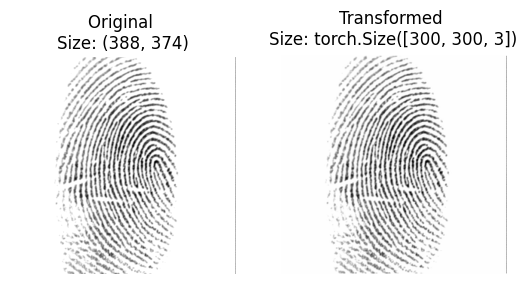

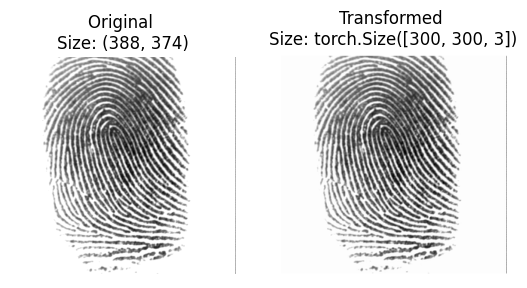

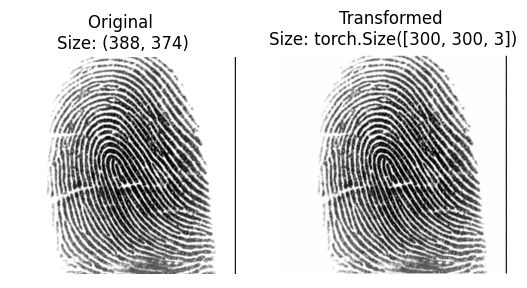

In [11]:
import matplotlib.pyplot as plt
def plot_transformed_images(img_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(img_paths, k=n)
  plt.figure(figsize=(200, 200))
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f, cmap='gray')
      ax[0].set_title(f'Original \nSize: {f.size}')
      ax[0].axis("off")

      image = ToTensor()(f).repeat(3, 1, 1).permute(1, 2, 0)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")


      if torch.equal(image, transformed_image):
          print("TRUE", image.shape, transformed_image.shape)
      else:
          print("FALSE", image.shape, transformed_image.shape)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [12]:
def class_finder(path: str):
  classes = list(set(int(entry.name.split('_')[0]) for entry in os.scandir(path)))
  classes.sort()

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {path}.")

  return tuple(classes)

In [13]:
# Create dataset
from torch.utils.data import Dataset
from typing import Tuple, List

class FingerprintData(Dataset):
  def __init__(self, targ_dir: str, transform=None) -> None:
    self.target_dir = targ_dir
    self.paths = list(Path(targ_dir).glob('*.tif'))
    self.transform = transform
    self.classes = class_finder(targ_dir)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int):
    index_1 = index // 8 + 1
    index_2 = index % 8 +1
    image_path = Path(self.target_dir) / f"{index_1}_{index_2}.tif"
    image = Image.open(image_path)

    if self.transform:
      return self.transform(image), index_1
    else:
      return image, index_1

In [14]:
train_data = FingerprintData(targ_dir=train_path,
                             transform=data_transform)

test_data = FingerprintData(targ_dir=test_path,
                             transform=data_transform)

In [15]:
len(train_data), len(test_data)

(800, 80)

In [16]:
train_data[5][1]

<ipython-input-6-62799896ee5d>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((new_width, new_height), Image.ANTIALIAS)


1

In [17]:
# DataLoader
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=0,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              num_workers=0,
                              shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7adae4727820>,
 <torch.utils.data.dataloader.DataLoader at 0x7adae4727fd0>)

In [18]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


<ipython-input-6-62799896ee5d>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((new_width, new_height), Image.ANTIALIAS)


Image shape: torch.Size([32, 3, 300, 300]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [19]:
print(label[:5])

tensor([69, 89, 43, 60, 63])


In [20]:
from torch import nn

class SharedNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # self.image = image
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=32,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                         stride=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,
                  out_channels=64,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                         stride=2)
    )

    self.block_3 = nn.Sequential(
        nn.Conv2d(in_channels=64,
                  out_channels=128,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.ReLU(),
        nn.Conv2d(in_channels=128,
                  out_channels=128,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                         stride=2),
        nn.Upsample(scale_factor=2,
                    mode='bilinear',
                    align_corners=True)

    )

    self.block_4 = nn.Sequential(
        nn.Conv2d(in_channels=128,
                  out_channels=128,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.ReLU(),
        nn.Upsample(scale_factor=2,
                    mode='bilinear',
                    align_corners=True)

    )

    self.inner_block = nn.Sequential(
        nn.Conv2d(in_channels=64,
                  out_channels=128,
                  kernel_size=1,
                  stride=1,
                  padding=0,
                  bias=False),
        nn.ReLU()
    )

    self.outer_block = nn.Sequential(
        nn.Conv2d(in_channels=32,
                  out_channels=128,
                  kernel_size=1,
                  stride=1,
                  padding=0,
                  bias=False),
        nn.ReLU()
    )

    self.final_block = nn.Sequential(
        nn.Conv2d(in_channels=128,
                  out_channels=256,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    stage_1 = self.block_1(x)
    print("Shape of stage_1: ", stage_1.shape)
    stage_2 = self.block_2(stage_1)
    print("Shape of stage_2: ", stage_2.shape)
    stage_3 = self.block_3(stage_2)
    print("Shape of stage_3: ", stage_3.shape)
    print("Shape of self.inner_block(stage_2): ",
          self.inner_block(stage_2).shape)

    inner_block_stage_2 = self.inner_block(stage_2)
    # inner_block_stage_2_padded = nn.functional.pad(inner_block_stage_2, (0, 0, 0, -1))
    # print("Shape of inner_block_stage_2_padded: ",
          # inner_block_stage_2_padded.shape)

    stage_3_padded = nn.functional.pad(stage_3, (0, 1, 0, 1))
    print("Shape of stage_3_padded: ", stage_3_padded.shape)

    L1 = torch.add(inner_block_stage_2, stage_3_padded)

    stage_4 = self.block_4(L1)
    # stage_3 = nn.functional.pad(stage_3, (0, 1, 0, 1)an)
    # stage_4 = nn.functional.pad(stage_4, (0, 0, 1, 0))

    L2 = torch.add(self.outer_block(stage_1),
                   stage_4)
    result = self.final_block(L2)

    return result

In [21]:
shared_nw_model = SharedNetwork()
shared_nw_model

SharedNetwork(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Upsample(scale_factor

Shape of stage_1:  torch.Size([1, 32, 150, 150])
Shape of stage_2:  torch.Size([1, 64, 75, 75])
Shape of stage_3:  torch.Size([1, 128, 74, 74])
Shape of self.inner_block(stage_2):  torch.Size([1, 128, 75, 75])
Shape of stage_3_padded:  torch.Size([1, 128, 75, 75])
torch.Size([1, 256, 150, 150])


TypeError: Invalid shape (150, 150, 256) for image data

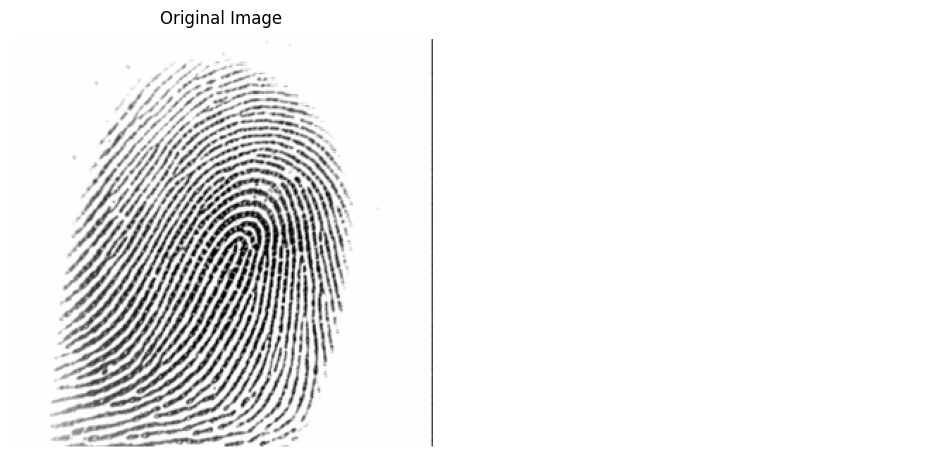

In [27]:
with torch.inference_mode():
  image = img[0].type(torch.float32).unsqueeze(0)
  result = shared_nw_model(image)
print(result.shape)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].axis("off")
axs[0].imshow(img[0].permute(1,2,0))
axs[0].set_title('Original Image')

axs[1].axis("off")
axs[1].imshow(result.squeeze(dim=0).permute(1,2,0))
axs[1].set_title('Feature Image')

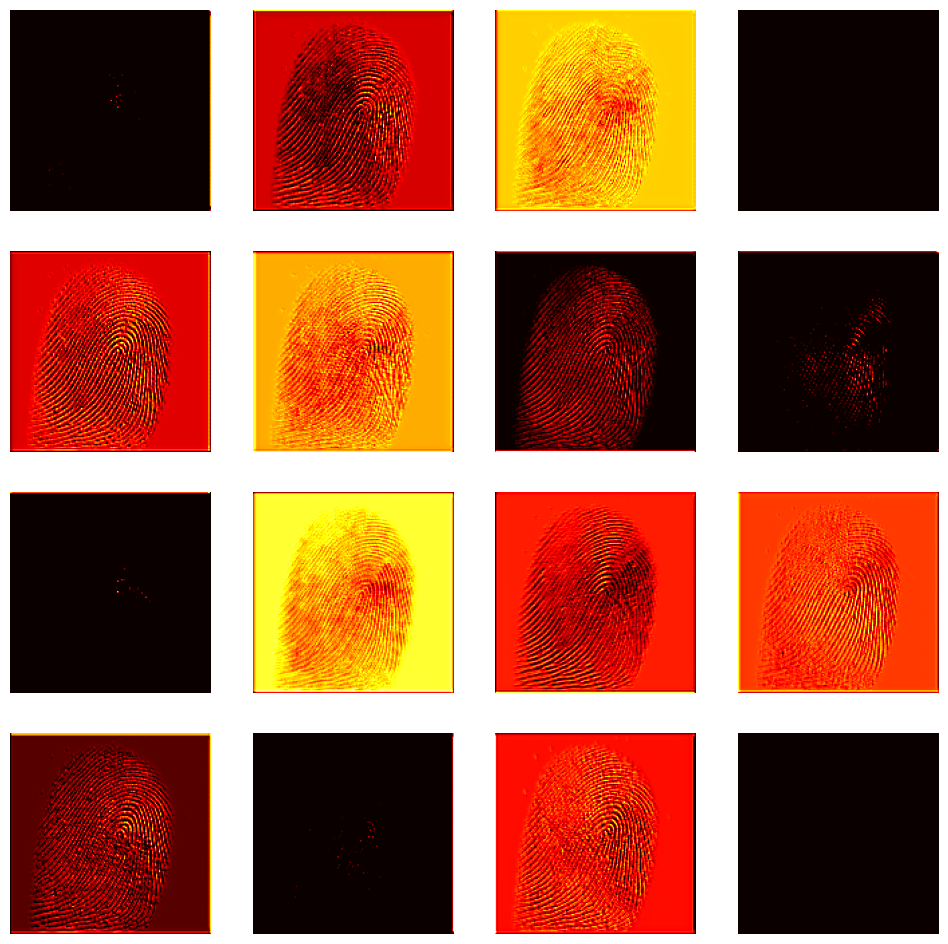

In [23]:

feature_map = result.squeeze(0)  # Remove the batch dimension

# Decide how many plots you want per row and per column
# For example, if you want to visualize only 16 feature maps in a 4x4 grid
rows, cols = 4, 4

fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows):
    for j in range(cols):
        # Select the feature map
        fmap = feature_map[i*cols + j].detach().numpy()
        ax[i, j].imshow(fmap, cmap='hot')
        ax[i, j].axis('off')

plt.show()

In [24]:
# Save the dataset and the model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "shared_feature_map_network.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=shared_nw_model.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/shared_feature_map_network.pth


In [25]:
# First stage
class FirstStageNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(256, 64, kernel_size=4, stride=4)  # Assuming input feature map has 128 channels
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1)  # 1x1 convolution to calculate scores
        self.pool = nn.AdaptiveMaxPool2d(1)  # Global Max Pooling to calculate coarse location

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Convolution with 4x4 kernel to divide feature map into cells
        scores = torch.sigmoid(self.conv2(x))  # 1x1 convolution to calculate scores
        coarse_location = self.pool(x)  # Global Max Pooling to calculate coarse location
        return scores, coarse_location